# Datasets and Evaluation

In this tutorial we will introduce the concept of a data set.

Then we will show how to evaluate a predictor with respect to a dataset and a metric.

**Caution!** This notebook will run only when at least the extended package **'tf-full', 'source-tf-full'** has been installed! Check the installation guidelines or the README for further informations. You will need to modify the script accordingly to run it with the PyTorch framework. 

## Dataset concept

A dataset is a class that consists of an info class, a category and a dataflow class. The dataflow class can be used to stream data point samples. Data points are image scans or single page pdfs from documents.

Data points are represented as `Image` class. This class has specific attributes to store several types of annotations. These annotations can be objects that determine the layout structure, like tables or table cells, words etc. Annotations are represented by another class `ImageAnnotation` that has attributes like bounding boxes, category names among other things.  

Dataflow is package that can be used to load and process data. Dataflow is a package that allows you to build chains of generators. Each dataflow chain member can be used to perform some specific tasks such as loading a or transforming a data point.

In [1]:
import deepdoctection as dd

from matplotlib import pyplot as plt

Let's print a list of all built-in datasets. 

In [2]:
dd.print_dataset_infos(add_license=False, add_info=False)

╒═══════════════╕
│ dataset       │
╞═══════════════╡
│ doclaynet     │
├───────────────┤
│ doclaynet-seq │
├───────────────┤
│ fintabnet     │
├───────────────┤
│ funsd         │
├───────────────┤
│ iiitar13k     │
├───────────────┤
│ testlayout    │
├───────────────┤
│ publaynet     │
├───────────────┤
│ pubtables1m   │
├───────────────┤
│ pubtabnet     │
├───────────────┤
│ rvl-cdip      │
├───────────────┤
│ xfund         │
╘═══════════════╛


With `get_dataset("pubtabnet")` we can create an instance of a built-in dataset.

In [21]:
pubtabnet = dd.get_dataset("pubtabnet")

print(pubtabnet.dataset_info.description)

PubTabNet is a large dataset for image-based table recognition, containing 568k+ images of 
tabular data annotated with the corresponding HTML representation of the tables. The table images 
 are extracted from the scientific publications included in the PubMed Central Open Access Subset 
 (commercial use collection). Table regions are identified by matching the PDF format and 
 the XML format of the articles in the PubMed Central Open Access Subset. More details are 
 available in our paper 'Image-based table recognition: data, model, and evaluation'. 
Pubtabnet can be used for training cell detection models as well as for semantic table 
understanding algorithms. For detection it has cell bounding box annotations as 
well as precisely described table semantics like row - and column numbers and row and col spans. 
Moreover, every cell can be classified as header or non-header cell. The dataflow builder can also 
return captions of bounding boxes of rows and columns. Moreover, various 

To install the data set, go to the url below and download the zip-file. 

In [4]:
pubtabnet.dataset_info.url

'https://dax-cdn.cdn.appdomain.cloud/dax-pubtabnet/2.0.0/pubtabnet.tar.gz?_ga=2.267291150.146828643.1629125962-1173244232.1625045842'

You will have to unzip and place the data set in your local **.cache/deepdoctection/dataset** directory. Once extracted, the dataset will already have the expected folder structure. If you are unsure, however, you can get some additional information about the physical structure by calling the dataset module docstring:

In [ ]:
pubtabnet.dataflow.get_workdir()

In [8]:
print(dd.datasets.instances.pubtabnet.__doc__)


Module for Pubtabnet dataset. Place the dataset as follows

|    pubtabnet
|    ├── test
|    │ ├── PMC1.png
|    ├── train
|    │ ├── PMC2.png
|    ├── val
|    │ ├── PMC3.png
|    ├── PubTabNet_2.0.0.jsonl



## Dataflow

We will now use the `build` method to display some data points. As already mentioned, the `build` method returns a generator from which you can create an iterator to stream your data.  

Let's display a tiny fraction of annotations that is available for each datapoint. `datapoint_dict["annotations"][0]` displays all informations that are available for a single cell. There is a `category_name` represented as `Enum` member. There is also a `bounding_box` and a dict called `sub_categories` that carries additional information relevant to a cell like `CellType.row_number`.

In [10]:
df = pubtabnet.dataflow.build(split="train") # get the dataflow generator
df.reset_state() # an intrinsic dataflow method that must always be called before streaming data. You will get an 
                 # error if you forget to do this.

df_iter = iter(df) 

datapoint = next(df_iter)

datapoint_dict = datapoint.as_dict() # displaying the Image class is very messy

datapoint_dict["file_name"],datapoint_dict["location"],datapoint_dict["_image_id"], datapoint_dict["annotations"][0]

('PMC4840965_004_00.png',
 PosixPath('/home/janis/.cache/deepdoctection/datasets/pubtabnet/train/PMC4840965_004_00.png'),
 'c87ee674-4ddc-3efe-a74e-dfe25da5d7b3',
 {'active': True,
  'external_id': None,
  '_annotation_id': '6a421e4d-143a-3ede-8494-9fbf5e8ef8b8',
  'category_name': <LayoutType.cell>,
  '_category_name': <LayoutType.cell>,
  'category_id': '1',
  'score': None,
  'sub_categories': {<CellType.row_number>: {'active': True,
    'external_id': None,
    '_annotation_id': 'fcbd492e-4fe1-3185-b8d6-fd0027e1957a',
    'category_name': <CellType.row_number>,
    '_category_name': <CellType.row_number>,
    'category_id': '28',
    'score': None,
    'sub_categories': {},
    'relationships': {}},
   <CellType.column_number>: {'active': True,
    'external_id': None,
    '_annotation_id': '1009bea2-272c-3a4b-abee-5e90a1d9c460',
    'category_name': <CellType.column_number>,
    '_category_name': <CellType.column_number>,
    'category_id': '3',
    'score': None,
    'sub_categor

Depending on the data set, different configurations of the `build` method can yield different representations of data points. For example, the underlying image is not loaded by default. By passing the parameter `load_image=True` the image will be loaded.

Note, that all images are loaded using the OpenCV framework, where colors are stored as array in BGR format. Matplotlib expects a numpy array in RGB order, which is why we have to swap dimensions. 

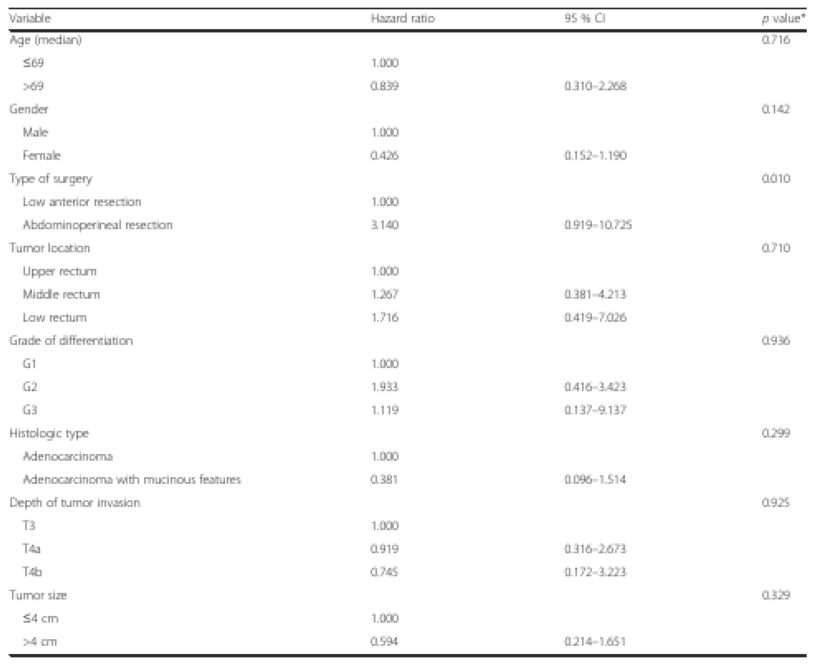

In [11]:
df = pubtabnet.dataflow.build(split="train",load_image=True)
df.reset_state()

df_iter = iter(df)
datapoint = next(df_iter)

plt.figure(figsize = (15,12))
plt.axis('off')
plt.imshow(datapoint.image[:,:,::-1])

It is possible to change the representation of a data point as already mentioned. For example, one can replace the category of an annotation with one of its sub-categories. 

Looking at this dataset, each cell has as a sub-category, stating if it is a table-header or a table-body cell. Using the method `dataflow.categories.set_cat_to_sub_cat` the main category can be replaced by one of its sub categories.

In [14]:
pubtabnet.dataflow.categories.set_cat_to_sub_cat({"cell":"header"})
df = pubtabnet.dataflow.build(split="train")
df.reset_state()

df_iter = iter(df)
datapoint = next(df_iter)

datapoint_dict = datapoint.as_dict()
datapoint_dict["file_name"],datapoint_dict["location"],datapoint_dict["_image_id"], datapoint_dict["annotations"][0]

('PMC4840965_004_00.png',
 PosixPath('/home/janis/.cache/deepdoctection/datasets/pubtabnet/train/PMC4840965_004_00.png'),
 'c87ee674-4ddc-3efe-a74e-dfe25da5d7b3',
 {'active': True,
  'external_id': None,
  '_annotation_id': '6a421e4d-143a-3ede-8494-9fbf5e8ef8b8',
  'category_name': <CellType.body>,
  '_category_name': <CellType.body>,
  'category_id': '2',
  'score': None,
  'sub_categories': {<CellType.row_number>: {'active': True,
    'external_id': None,
    '_annotation_id': 'fcbd492e-4fe1-3185-b8d6-fd0027e1957a',
    'category_name': <CellType.row_number>,
    '_category_name': <CellType.row_number>,
    'category_id': '28',
    'score': None,
    'sub_categories': {},
    'relationships': {}},
   <CellType.column_number>: {'active': True,
    'external_id': None,
    '_annotation_id': '1009bea2-272c-3a4b-abee-5e90a1d9c460',
    'category_name': <CellType.column_number>,
    '_category_name': <CellType.column_number>,
    'category_id': '3',
    'score': None,
    'sub_categories'

This data set was used to train the cell detector of the **dd-analyzer**.

In the section that follows now, we will show how to measure the performance of the detector on the Pubtabnet validation split. After that, we are going to measure the performance on another dataset that has documents from a different domain.

## Evaluation

In many situation you are not interested in raw predictions of a model but on results which have been polished through several post-processing steps. In other situations, you want to measure accuracy/precision etc. not after running one but several models. For example, getting the html representation of a table requires output from several predictors. Evaluating along a pipeline allows you to see how model prediction(s) and post processing works in conjunction. 
**deep**doctection therefore comes equipped with an evaluator that allows you to run evaluation not on a model directly but on a pipeline component or a full pipeline.   

An evaluator needs three things to be constructed:

- a dataset
- a pipeline component or a pipeline and 
- a metric. 

In this notebook, we are going to evaluate the cell prediction model run on the Pubtabnet evaluation split.
We measure performance using mean average precision/ mean average recall. This metric has been implemented by pycocotools. In contrast to traditional object detection task we need to consider that

- objects to be identified are generally smaller
- there are many objects to identify.

Therefore, we change the maximum number of detections to consider and also choose a different scale for grouping cells into one of the categories: small, medium and large.

In [15]:
config_yaml_path = dd.ModelCatalog.get_full_path_configs("cell/model-1800000.data-00000-of-00001")
weights_path = dd.ModelCatalog.get_full_path_weights("cell/model-1800000.data-00000-of-00001")

In [17]:
coco_metric = dd.get_metric("coco")
coco_metric.set_params(max_detections=[50,200,600], area_range=[[0,1000000],[0,200],[200,800],[800,1000000]])

Pubtabnet does not only have ground truth for cells but also for rows and columns. As our model only predicts cells we need to filter out ground truth for objects that cannot be detected by the model. 

In [ ]:
pubtabnet = dd.get_dataset("pubtabnet")
pubtabnet.dataflow.categories.filter_categories(categories="cell")
categories = pubtabnet.dataflow.categories.get_categories(filtered=True) # this will return a dict {"1": <LayoutType.cell>}

cell_detector = dd.TPFrcnnDetector("cell", config_yaml_path,weights_path,categories)
layout_service = dd.ImageLayoutService(cell_detector)

We start evaluation using the `run` method. `max_datapoints` limits the number of samples to at most 100 samples. The `val` split is used by default.

In [ ]:
evaluator = dd.Evaluator(pubtabnet,layout_service, coco_metric)
output= evaluator.run(max_datapoints=100)

`Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=600 ] = 0.970
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=600 ] = 0.948
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=600 ] = 0.817
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=600 ] = 0.860
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=600 ] = 0.840
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 50 ] = 0.538
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=200 ] = 0.864
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=600 ] = 0.874
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=600 ] = 0.852
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=600 ] = 0.891
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=600 ] = 0.864`

We are now going to evaluate the cell predictor on tables from business documents. One difference from the example before is the representation of the dataset. Unlike Pubtabnet where tables have been cropped from their surronding document, the images of Fintabnet are whole document pages. In order to get tables only, we pass a special argument to the `build` method, that only affects changes for this datase: `build_mode = "table"`. Under the hood this will crop tables from the image and also adjust cell bounding boxes, so that the datapoints will look like datapoints from Pubtabnet. 

We neither change pipeline component not metric. 

In [ ]:
fintabnet = dd.get_dataset("fintabnet")
fintabnet.dataflow.categories.filter_categories(categories="cell")

evaluator = dd.Evaluator(fintabnet,layout_service, coco_metric)
output= evaluator.run(max_datapoints=100,build_mode="table",load_image=True, use_multi_proc=False)

` Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=600 ] = 0.911
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=600 ] = 0.709
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=600 ] = 0.559
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=600 ] = 0.570
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=600 ] = 0.700
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 50 ] = 0.590
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=200 ] = 0.657
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=600 ] = 0.657
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=600 ] = 0.638
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=600 ] = 0.636
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=600 ] = 0.774`

What stands out ? 

The mAP for a low IoU drops a bit. While the mAP for higher IoUs drops only slightly compared to Pubtabnet, it drops much more for higher IoUs. This means that the cell detector has much more problems in its precision. It recognizes the almost the same amount of cells, however it struggles to determine bounding boxes that precisely cover the area of a cell.  

# How to continue

In the last **Fine_Tune** notebook tutorial, we will discuss training a Tensorpack Predictor on a dataset.